# Load a tracked particle and movie to see if locating workd

### Written by Matan 20230106

In [1]:
#%matplotlib inline
%matplotlib widget


In [2]:
#############imports######################################################################
import cv2 as cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
from ipywidgets import HBox, Textarea, interact


In [3]:
################functions1##################################################################
def l2n(x):
    return np.array(x)
def parseCircles(circles):
    x = []
    y = []
    r = []
    for i in range(len(circles)):
        x.append(circles[i,0,0])
        y.append(circles[i,0,1])
        r.append(circles[i,0,2])
        
    x,y,r = l2n(x), l2n(y),l2n(r)
    return x,y,r

In [4]:
#########################functions2#########################################################
def preProcessFrame(frame):
    #blur and grayout a frame
    
    # Convert to grayscale.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      
    # Convert to HSV and extract the saturation channel
    #sat = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)[:,:,0]

    # median filter
    #median = cv2.medianBlur(gray, 3)
    #gray_blurred = median
    # Blur using 3 * 3 kernel.
    blurSize = 10#5
    gray_blurred = cv2.blur(gray, (blurSize, blurSize))
    
    return gray_blurred

def detectCircles(frame,minRadius,maxRadius,param1=30,param2=25):
    
    minDist = minRadius-1
    dp = 0.5
    # Apply Hough transform on the blurred image.
    circles = cv2.HoughCircles(frame, 
                cv2.HOUGH_GRADIENT,dp, minDist, param1 = param1,
                param2 = param2, minRadius = minRadius, maxRadius = maxRadius)

    return circles
    
def captureFrame(video,frame_id):
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = video.read()
    if ret:
        return frame
    else:
        return ret

def drawCircles(circles,ax ):
    if circles is not None:  
    # Convert the circle parameters a, b and r to integers.
    #detected_circles = np.uint16(np.around(detected_circles))
    #fig, ax = plt.subplots() 
        for pt in circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]
            circle = plt.Circle((a, b), r, color='r',fill=False)
            ax.add_patch(circle)
            #ax.imshow(frame, cmap = 'gray')

def drawCirclesDf(df,ax ):
    
    
    for index, row in df.iterrows():
        x,y,r = row.x,row.y,row.r
        circle = plt.Circle((x, y), r, color='r',fill=False)
        ax.add_patch(circle)

def circlesToDataFrame(circles,frameNum):    
    x,y,r = parseCircles(circles)
    data = {'frame':[int(frameNum)]*len(circles),'x':x,'y':y,'r':r}
    dft = pd.DataFrame(data = data)
    
    return dft


def cropImage(img,x0,y0,width,height):
    return img[y0:y0+height,x0:x0+width,:]
'''def cropImage(img,x0,y0,width,height):
    d = len(img.shape)
    if d==2: #grayscale
        return img[y0:y0+height,x0:x0+width]
    elif d==3: #rgb
        return img[y0:y0+height,x0:x0+width,:]
'''

'def cropImage(img,x0,y0,width,height):\n    d = len(img.shape)\n    if d==2: #grayscale\n        return img[y0:y0+height,x0:x0+width]\n    elif d==3: #rgb\n        return img[y0:y0+height,x0:x0+width,:]\n'

In [161]:
expSumFileName = 'transportExpSum20230305bots21_.csv'
expSum = pd.read_csv(experimentsSummaryFileName,index_col=0)

In [5]:
#########################video_filenames###############################################
#fileName = "D:\Eden\20221208\fronters22\C0486shortLabeled.MP4"

#VERY GOOD
#fileName = 'D:\\Eden\\20221213\\fronters21\\C0492.MP4'
locateFileNameSuffix = '_locatedFull20230107a.csv'#suffix of the 
#fileNameVideo = 'D:\\Matan\\20221217\\fronters53passive28cm\\C0505.MP4'#'D:\\Eden\\29_12_22\\frontes_21_7cm\\C0538.MP4'#'D:\\Eden\\29_12_22\\aligners_21_7cm\\C0547.MP4'#'D:\\Eden\\3_1_23\\aligners_21_32cm\\C0552.MP4' #'D:\\Eden\\20221213\\fronters21\\C0492.MP4'#'D:\\Matan\\20221218\\aligners53passive28cm\\C0510.MP4'#'D:\\Eden\\20221213\\aligners21\\C0494.MP4'#'D:\\Eden\\5_1_23\\fronters8passive28cm\\C0562.MP4' #'D:\\Eden\\5_1_23\\fronters8passive28cm\\C0562.MP4'
fileNameVideo = 'D:\\Eden\\27_12_22\\fronters-12cm\\C0535.MP4'#'test.mp4'#'./C0511coppedTrimmedGray.MP4'
fileNameLocated = fileNameVideo+locateFileNameSuffix
arenaSizePixels = 1090 # [pixels]
arenaSizeCm = 150 # [cm]



### Fetch Experiments details from experiment summary table

In [162]:
expNum = 8

In [164]:
expSum.head()

,date,operator,bottype,stars,bots,passiveDiameter[cm],path,locatingFileName,minCircleRadius,maxCircleRadius,...,frames,pixelSize [cm/pixel],pixelSize_unbined [cm/pixel],arenaSize[cm],turnOnTime [s],comments,backedup,130,production,linkingFileName
0,20221229.0,Eden,aligner,NaN,21.0,7.0,D:\Eden\29_12_22\aligners_21_7cm\C0548.MP4,D:\Eden\29_12_22\aligners_21_7cm\C0548.MP4_loc...,22.0,28.0,...,NaN,0.137615,NaN,150.0,NaN,1low bot-replaced,NaN,NaN,NaN,D:\Eden\29_12_22\aligners_21_7cm\C0548.MP4_loc...
1,20221229.0,Eden,aligner,NaN,21.0,7.0,D:\Eden\29_12_22\aligners_21_7cm\C0547.MP4,D:\Eden\29_12_22\aligners_21_7cm\C0547.MP4_loc...,22.0,28.0,...,NaN,0.137615,NaN,150.0,NaN,1low bot-replaced,NaN,NaN,NaN,D:\Eden\29_12_22\aligners_21_7cm\C0547.MP4_loc...
2,20221229.0,Eden,aligner,NaN,21.0,7.0,D:\Eden\29_12_22\aligners_21_7cm\C0544.MP4,D:\Eden\29_12_22\aligners_21_7cm\C0544.MP4_loc...,22.0,28.0,...,NaN,0.137615,NaN,150.0,NaN,1 spinning bot-replaced,NaN,NaN,NaN,D:\Eden\29_12_22\aligners_21_7cm\C0544.MP4_loc...
3,20221229.0,Eden,aligner,NaN,21.0,7.0,D:\Eden\29_12_22\aligners_21_7cm\C0542.MP4,D:\Eden\29_12_22\aligners_21_7cm\C0542.MP4_loc...,22.0,28.0,...,NaN,0.137615,NaN,150.0,NaN,1 spinnig bot plastic replaced,NaN,NaN,NaN,D:\Eden\29_12_22\aligners_21_7cm\C0542.MP4_loc...
4,20221229.0,Eden,fronter,NaN,21.0,7.0,D:\Eden\29_12_22\frontes_21_7cm\C0541.MP4,D:\Eden\29_12_22\frontes_21_7cm\C0541.MP4_loca...,22.0,28.0,...,NaN,0.137615,NaN,150.0,NaN,NaN,NaN,NaN,NaN,D:\Eden\29_12_22\frontes_21_7cm\C0541.MP4_loca...


In [165]:
row = expSum.iloc[expNum]

passiveDiameter = row['passiveDiameter[cm]']
fileNameLinked = 'temporaryLinkingFile.csv'#row.linkingFileName
fileNameVideo = row.path

In [166]:
row.linkingFileName

'D:\\Eden\\27_12_22\\fronters-12cm\\C0537.MP4_locatedFull20230223a_test_eden.csv_linked.csv'

In [153]:
# Load video file
video = cv2.VideoCapture(fileNameVideo)
# Load locating file
df = pd.read_csv(fileNameLinked)

#get videos properties
width  = video.get(cv2.CAP_PROP_FRAME_WIDTH )
height = video.get(cv2.CAP_PROP_FRAME_HEIGHT )
fps = video.get(cv2.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
frameCount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
pixelSize = arenaSizeCm/arenaSizePixels

In [154]:
fps

25.0

In [155]:
pixelSize

vInst = 20*pixelSize*fps
vInst

68.80733944954129

## Locating params 

frameMin=0
frameNum = frameMin

frameNum = 1000

boxSize = int(2*(2*radiusMax))
boxSize = 300
wc,hc = boxSize,boxSize
#xc,yc = int(958-boxSize/2),int(548-boxSize/2)
xc,yc = boxSize/2,boxSize/2

fig,ax= plt.subplots()
img = captureFrame(video,frameNum)
#imgRed = img[:,:,0]
#imgCropped = cropImage(imgRed,x0,y0,width0,height0)
imgCropped = img#cropImage(img,xc,yc,wc,hc)

imgE = cv2.Canny(imgCropped,threshMin,threshMax)

ax.imshow(imgCropped)
#drawCircles(circles,plt.gca())

In [156]:
plt.ioff()
fig1 = plt.figure()
ax1 = fig1.gca()
#ax.imshow(frame,cmap='Greys')
plt.ion()
#fig1.canvas

In [158]:
########################################widget_cell#####################################################################################
#fig,ax = plt.subplots()
starting_point=1000
frame_step=100
maxFrame = 20000#frameCount
frameRange= range(starting_point,maxFrame,frame_step)
@interact(frameNum=frameRange)#df.frame.values)
def drawPassiveParticleOnFrame(frameNum):
    
    dff =df[df.frame==frameNum]
    
    x,y,r = dff.x.values,dff.y.values,dff.r.values
    
    circles = [[x,y,r]]
    img  = captureFrame(video,frameNum)
    imgCropped =cropImage(img,300,0,1200,int(height))
    
    ax1.cla()
    ax1.imshow(imgCropped)
    drawCirclesDf(dff,ax1)
    tp.plot_traj(df[df.frame<frameNum],ax=ax1)
    #ax.imshow(img, cmap='Greys')
    
HBox([fig1.canvas])

interactive(children=(Dropdown(description='frameNum', options=(1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700…

In [ ]:
row.

In [128]:
len(df)

30475

In [129]:
imsd = tp.imsd(df,pixelSize,fps,max_lagtime=10000)

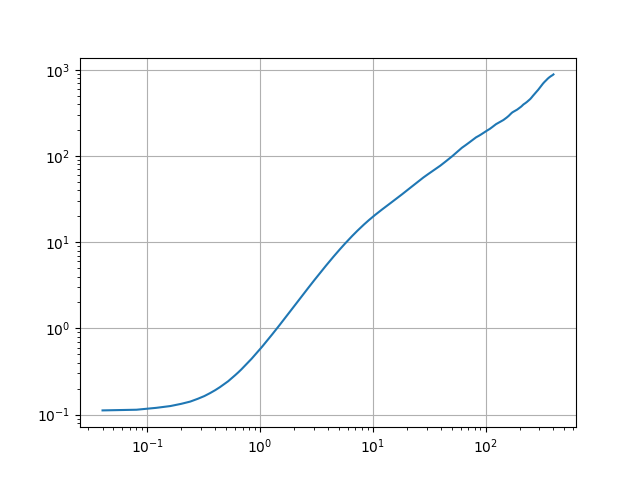

In [131]:
fig2,ax2 = plt.subplots()

ax2.loglog(imsd)
ax2.grid()
#tp.plot_traj(df,ax=ax2)

In [136]:
#######################figures stataistic of dx dy dr################################
period = 50
dx,dy,dr=df.x.diff(period),df.y.diff(period),df.r.diff(period)
plt.figure()
fig1, axis = plt.subplots(3,1)
axis[0].plot(dx)
axis[0].set_title("dx")
axis[1].plot(dy)
axis[0].set_title("dy")
axis[2].plot(dr)
axis[0].set_title("dr")
plt.legend()
plt.show()


n_bins = 100
plt.figure()
fig2, axs = plt.subplots(3,1)
axs[0].hist(dx,bins=n_bins)
axs[0].set_title("dx")
axs[0].set_yscale('log')
axs[1].hist(dy,bins=n_bins)
axs[1].set_title("dy")
axs[1].set_yscale('log')
axs[2].hist(dr,bins=n_bins)
axs[2].set_title("dr")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'dr')

In [122]:
vNom = 1#cm/s
deltaNom = vNom/fps
deltaNomPix = deltaNom/pixelSize
deltaNomPix

0.2906666666666667

In [135]:
#fig,ax=plt.subplots()
ts = np.random.normal(size=10000)

#ax.hist(ts,bins=25)
#ax.set_yscale('log')
#plt.show()

In [110]:
print('hello')

hello


In [111]:
cv2.imshow('Frame', img)

In [112]:
t = tp.link(df,search_range=20,memory=10)

Frame 26960: 1 trajectories present.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [113]:
t.particle.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

In [114]:
t1 = tp.filter_stubs(t,threshold=1000)

In [115]:
#t1 = df.copy()
#t1['particle']=0

In [116]:
imsd = tp.imsd(t1,fps = fps,mpp=pixelSize, max_lagtime=10000)

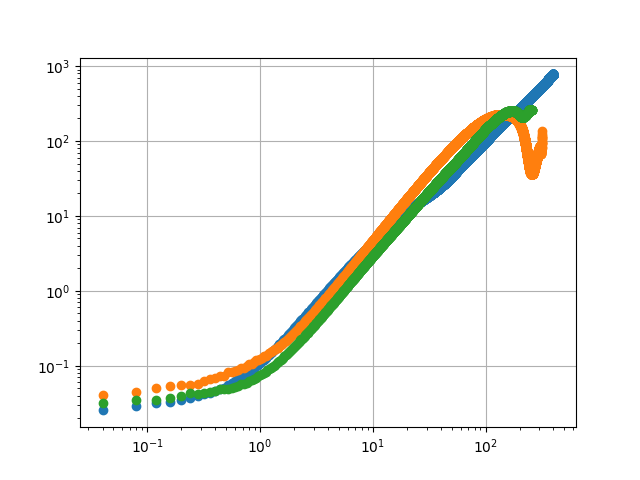

In [117]:
fig3,ax3 = plt.subplots()
ax3.loglog(imsd,'o')
ax3.grid()

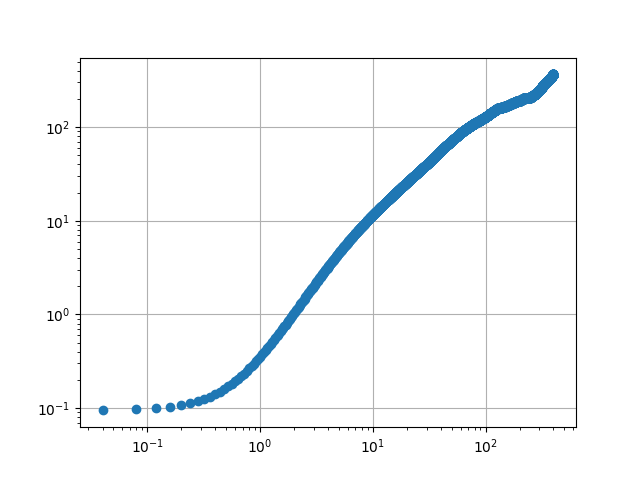

In [126]:
fig2,ax2 = plt.subplots()
ax2.loglog(imsd,'o')
ax2.grid()

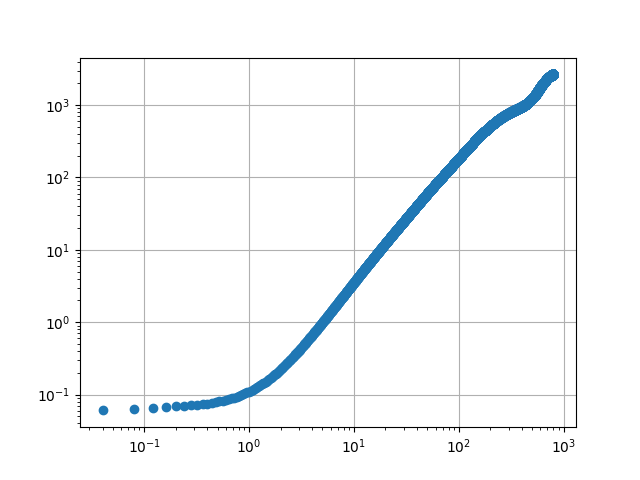

In [67]:
fig1,ax1 = plt.subplots()
ax1.loglog(imsd,'o')
ax1.grid()

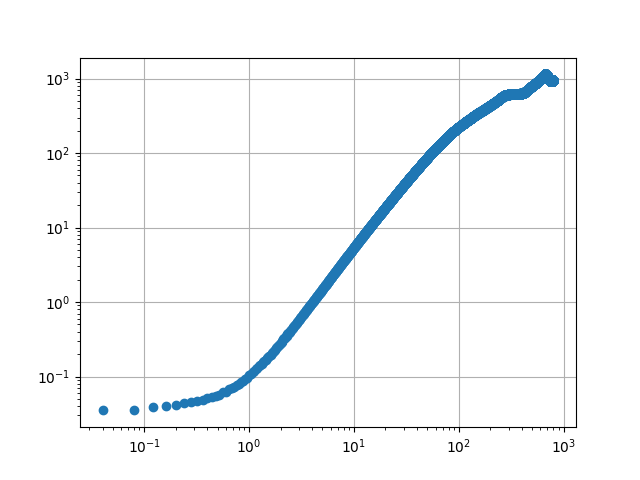

In [34]:
fig,ax = plt.subplots()
ax.loglog(imsd,'o')
ax.grid()

In [133]:
0.05**0.5

0.22360679774997896

In [55]:
#for optimizing params1 and param2
xSTD,ySTD,rSTD = [],[],[]
params1,params2 = [],[]


In [80]:
0.3**2

0.09

In [ ]:
%%time

minFrame = 250
frameSkip = 1
frameMax = minFrame+2000#300#frameCount#minFrame+3*60*24

#for cargo:
#outer Radius
minRadius = 102#102
maxRadius = 105#105

#inner Radius
minRadius = 183#86
maxRadius = 190#90


#Higher values, higher tolerances:

#How sharp of an edge
param1 = 25#100#25#35#30#25#25
#How many points
param2 = 10#35

#for robots:
#minRadius = 7
#maxRadius = 15
#param1 = 30
#param2 = 25

frameRange = range(minFrame,frameMax,frameSkip)
circlesAll = []
framesTracked = []
data = {'frame':[],'x':[],'y':[],'r':[]}
#dtypes = 

#data = np.array([(), (), (),()],
#               dtype=[('frame', 'int32'), ('x', 'float32'), ('y', 'float32'),('r','float32')])

columns = ['frame','x','y','r']
df = pd.DataFrame(data=data,columns=columns)

for frameNum in frameRange:
    frame = captureFrame(video,frameNum)
    frameProc = preProcessFrame(frame)
    #Increase resolution for "sub-pixel" accuracy on circle detection
    res = cv2.resize(frameProc, dsize=(int(width*2), int(height*2)), interpolation=cv2.INTER_CUBIC)
    circles = detectCircles(res,minRadius,maxRadius,param1,param2)
    #circles = detectCircles(frameProc,minRadius,maxRadius,param1,param2)
    
    
    if circles is not None:
        circlesAll.append(circles)
        framesTracked.append(frameNum)
        x,y,r = parseCircles(circles)
        data = {'frame':[int(frameNum)]*len(circles),'x':x,'y':y,'r':r}
        dft = pd.DataFrame(data = data)
        df = pd.concat([df,dft],ignore_index=True)
    
df = df.astype({"frame": int})

In [10]:
x0,y0 = 310,0
width0,height0 = 1160,1080

#frameNum = 1500
threshMin = 10
threshMax = 300

radiusMin = 22
radiusMax = 24

param1 = 35#100#25#35#30#25#25
param2 = 10#35



frameRange = df.frame.unique()#range(frameMin,frameMax,frameSkip)


In [215]:
df

,frame,x,y,r
0,250,1922.5,1145.5,185.000000
1,251,1921.5,1146.5,184.899994
2,252,1921.5,1149.5,185.000000
3,253,1921.5,1147.5,183.899994
4,254,1921.5,1148.5,184.899994
...,...,...,...,...
1995,2245,2276.5,1176.5,183.600006
1996,2246,2277.5,1176.5,183.600006
1997,2247,2275.5,1176.5,184.100006
1998,2248,2275.5,1176.5,183.899994


In [58]:
df.to_csv(fileName+'_locatedFull_20221214.csv')

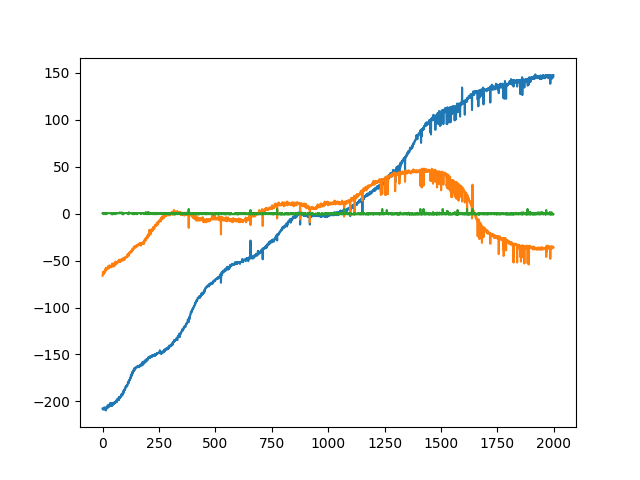

In [216]:
fig,ax = plt.subplots()

ax.plot(df.x-df.x.mean())
ax.plot(df.y-df.y.mean())
ax.plot(df.r-df.r.mean())
#ax.plot(np.diff(df.frame))

In [218]:
#fig,ax = plt.subplots()
@interact(frameNum=df.frame.values)
def drawPassiveParticleOnFrame(frameNum):
    
    dff =df[df.frame==frameNum]
    
    x,y,r = dff.x.values,dff.y.values,dff.r.values
    
    circles = [[x,y,r]]
    frame  = captureFrame(video,frameNum)
    ax.cla()
    ax.imshow(frame)
    drawCirclesDf(dff/2,ax)
    
    #ax.imshow(img, cmap='Greys')
    
HBox([fig.canvas])

interactive(children=(Dropdown(description='frameNum', options=(250, 251, 252, 253, 254, 255, 256, 257, 258, 2…

In [219]:
dfc=df.copy()
dfc.frame = df.frame/frameSkip
dfc = dfc.astype({"frame": int})

In [226]:

t = tp.link(dfc,search_range=10,memory=5)
t = tp.filter_stubs(t,threshold=100)

Frame 1748: 1 trajectories present.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [227]:
mpp = arenaSizeCm/arenaSizePixels #[cm/pixel]
mpp = arenaSizeCm/arenaSizePixels/2 #[cm/pixel]
imsd = tp.imsd(t,fps=fps/frameSkip,mpp=mpp,max_lagtime=30000)

In [171]:
imsd.to_csv(fileName+'MSDxxx20221214.csv')

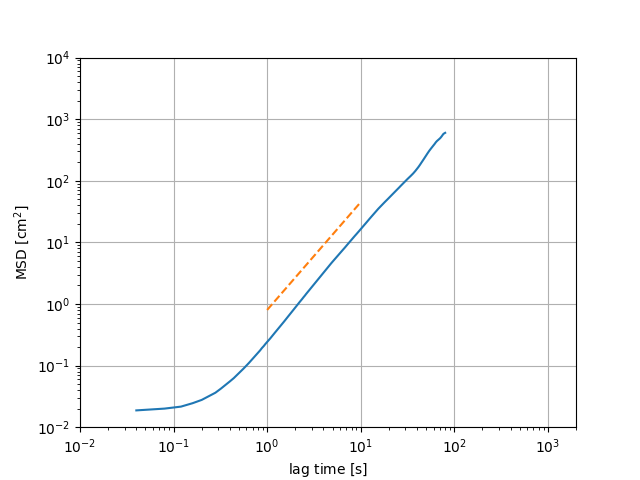

In [228]:
fig,ax = plt.subplots()
ax.loglog(imsd.index,imsd,label='msd')
#ax.plot(df.frame,df.x)
#ax.plot(df.frame,df.y)
x = np.linspace(1,10,10)
y = 0.08E1*x**1.75
ax.loglog(x,y,'--',label='1.75')

ax.axis([0.01,2000,0.01,1E4])
ax.grid()

ax.set_xlabel(r'lag time $\left[\rm{s}\right]$')
ax.set_ylabel(r'MSD $\left[\rm{cm}^2\right]$')

fig.savefig('MSDC0492__.png',bbox_inches='tight')

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

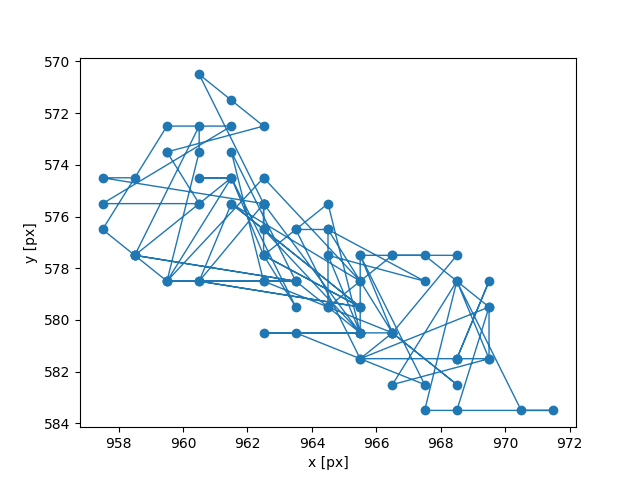

In [156]:
fig,ax=plt.subplots()

tp.plot_traj(t,ax=ax,plot_style={'marker':'o'})

In [276]:
params1.append(param1)
params2.append(param2)
xSTD.append(df.x.std())
ySTD.append(df.y.std())
rSTD.append(df.r.std())

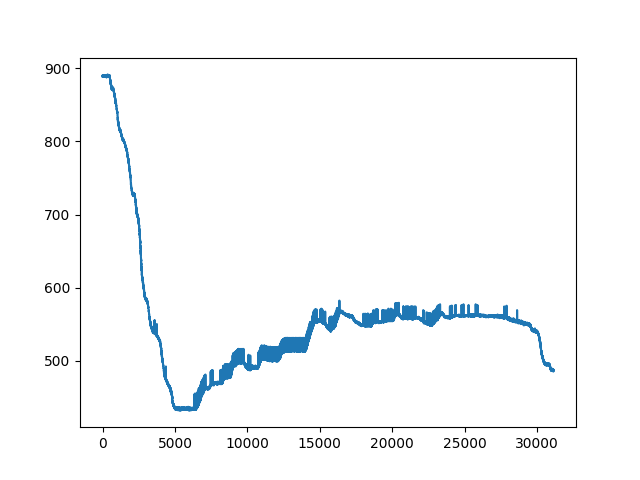

In [24]:
fig,ax=plt.subplots()
ax.plot(t.x)

In [310]:
75**2

5625

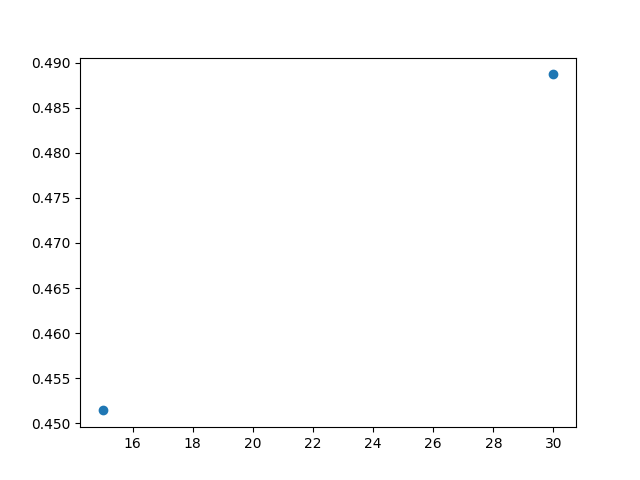

In [173]:
fig,ax = plt.subplots()
ax.plot(params1,rSTD,'o')

In [174]:
rSTD.append(df.r.std())

In [117]:
len(frameRange)

20

In [118]:
pwd

'D:\\Eden\\analysis\\sandbox'

(0.0, 264.22018348623857, 0.0, 148.6238532110092)

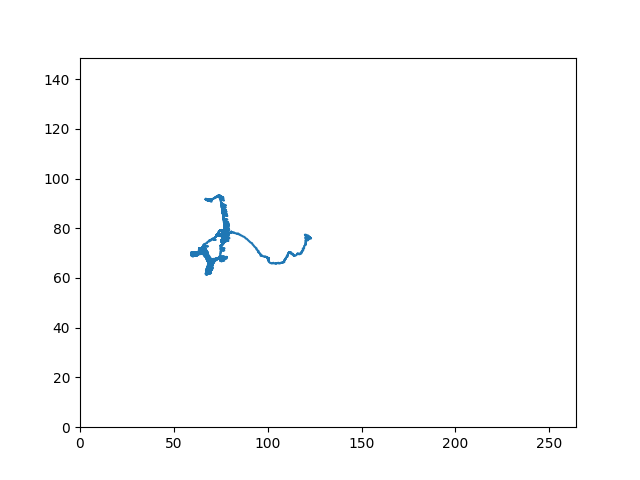

In [234]:
fig,ax = plt.subplots()
x,y=df.x,df.y

ax.plot(x*mpp,y*mpp)
ax.axis([0,width*mpp,0,height*mpp])
#plt.show()

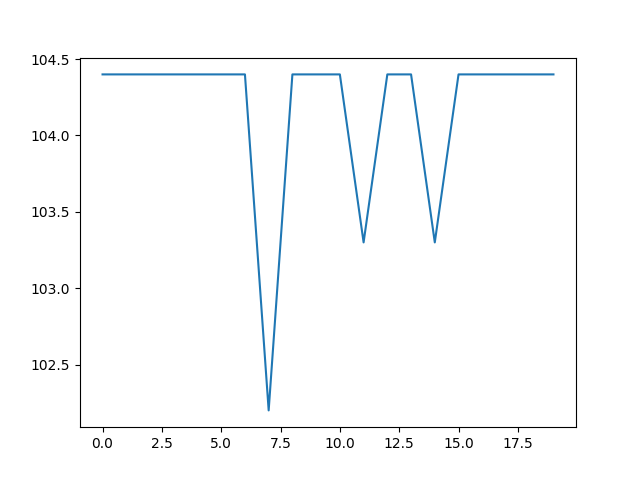

In [258]:
t.head()

,frame,x,y,r,particle
0,500,887.5,554.5,103.300003,0
1,501,887.5,553.5,103.300003,0
2,502,886.5,554.5,104.400002,0
3,503,887.5,555.5,104.400002,0
4,504,887.5,554.5,103.300003,0


In [259]:
t.frame.max()

699

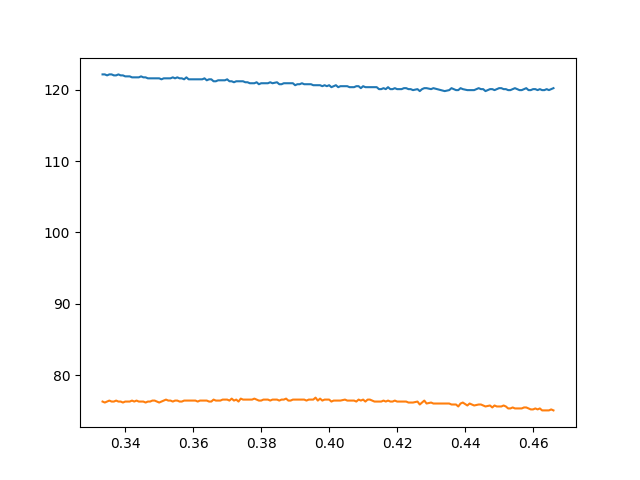

In [261]:
fig,ax = plt.subplots()
#ax.loglog(imsd.index,imsd)
frameToMin = 1/fps/60
ax.plot(df.frame*frameToMin,df.x*mpp)
ax.plot(df.frame*frameToMin,df.y*mpp)

In [255]:
150/1080

0.1388888888888889

In [209]:
cv2.imwrite('frame.png',frame)

True

In [137]:
fig,ax=plt.subplots()
ax.imshow(img[200:1000,200:1000,:])
fig.savefig('figname.png',dpi='figure')

# Archive

### Use static cropping

In [135]:
'''%%time

data = {'frame':[],'x':[],'y':[],'r':[]}
columns = ['frame','x','y','r']
df = pd.DataFrame(data=data,columns=columns)
for frameNum in frameRange:
    
    img = captureFrame(video,frameNum)
    imgRed = img[:,:,0]
    imgCropped = cropImage(imgRed,x0,y0,width0,height0)
    
    imgE = cv2.Canny(imgCropped,threshMin,threshMax)

    circles = detectCircles(imgE,radiusMin, radiusMax,param1,param2)
    
    if circles is not None:        
        dft = circlesToDataFrame(circles)
        df = pd.concat([df,dft],ignore_index=True)
'''

CPU times: total: 38min 51s
Wall time: 5min 49s
